<a href="https://colab.research.google.com/github/AlessioChen/Computer-Vision-Class/blob/main/CV_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchsummary import summary

In [2]:
# @title Train method
def train(model, device, train_loader, optimizer, epoch):
  model.train()
  losses = []
  for batch_idx, (data, target) in enumerate(train_loader):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()

    # Forward pass
    output = model(data)

    # Compute loss and save loss
    loss = F.nll_loss(output, target)
    losses.append(loss.item())

    # Backword pass and optimization step
    loss.backward()
    optimizer.step()

    if batch_idx % 500 == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
          epoch, batch_idx * len(data), len(train_loader.dataset),
          100. * batch_idx / len(train_loader), loss.item()))

  return np.mean(losses)

In [3]:
# @title Test method
def test(model, device, test_loader):
  model.eval()
  test_loss = 0
  correct = 0

  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)

      output = model(data)

      # sum up batch loss
      test_loss += F.nll_loss(output, target, reduction='sum').item()

      # get the index of the max log-probability
      pred = output.argmax(dim=1, keepdim=True)

      # get number of correct predictions
      correct += pred.eq(target.view_as(pred)).sum().item()

  test_loss /= len(test_loader.dataset)
  test_accuracy = correct / len(test_loader.dataset)

  print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
      test_loss, correct, len(test_loader.dataset),
      100. * correct / len(test_loader.dataset)))

  return test_loss, test_accuracy


In [4]:
# @title Train and evaluate
def train_and_evaluate(model, train_loader, test_loader, num_epochs=5, learning_rate=0.01):




    model.to(device)
    optimizer = optim.SGD(model.parameters(), lr=lr)
    train_losses = []
    test_losses = []
    test_accuracies = []

    for epoch in range(1, num_epochs + 1):
      train_losss = train(model, device, train_loader, optimizer, epoch)
      test_loss, test_accuracy = test(model, device, test_loader)

      train_losses.append(train_losss)
      test_losses.append(test_loss)
      test_accuracies.append(test_accuracy)
      print(f'Epoch {epoch}/{num_epochs}, Loss: {train_losses[-1]:.4f}, Test Accuracy: {test_accuracy:.2f}%')

    return train_losses, test_accuracies

# Download and transform MNIST dataset

In [5]:
transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)) # Normalize matrix
])

train_dataset = datasets.MNIST(root='./data/', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data/', train=False, transform=transform, download=True)


print(train_dataset.data.shape)
print(test_dataset.data.shape)

torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])


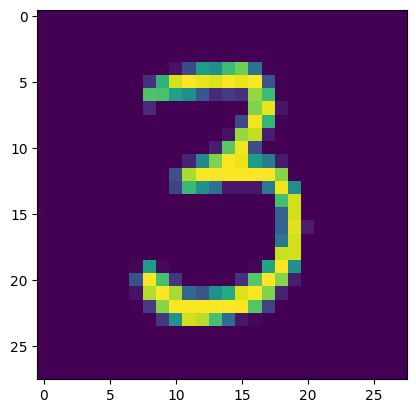

In [6]:
plt.imshow(train_dataset.data[50])
plt.show()

# Network with one layer

In [7]:
class OneLayerNet(nn.Module):
  def __init__(self):
    super(OneLayerNet, self).__init__()
    self.fc1 = nn.Linear(28*28, 10) # images are 28x28 pixels, 10 classes for output

  def forward(self, x):
    x = x.view(-1, 28*28) # flattern the image
    x = self.fc1(x)
    output = F.log_softmax(x, dim=1)
    return output


# Multi layer perceptron


In [8]:
class MultiLayerPerceptrionNet(nn.Module):
  def __init__(self):
    super(MultiLayerPerceptrionNet, self).__init__()
    self.fc1 = nn.Linear(28*28, 700)
    self.fc2 = nn.Linear(700, 500)
    self.fc3 = nn.Linear(500, 300)
    self.fc4 = nn.Linear(300, 10)

  def forward(self, x):
    x = x.view(-1, 28*28) # flattern the image

    x = self.fc1(x)
    x = F.relu(x)

    x = self.fc2(x)
    x = F.relu(x)

    x = self.fc3(x)
    x = F.relu(x)

    x = self.fc4(x)
    output = F.log_softmax(x, dim=1)


    return output

# Convolutional Network

In [9]:
class ConvNet(nn.Module):
  def __init__(self):
    super(ConvNet, self).__init__()
    self.conv1 = nn.Conv2d(1, 16, 3, 1) # input channels, output channels, kernel size, stride
    self.conv2 = nn.Conv2d(16, 32, 3, 1)
    self.fc1 = nn.Linear(32 * 12 * 12, 128)
    self.fc2 = nn.Linear(128, 10)


  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)

    x = self.conv2(x)
    x = F.relu(x)

    x = F.max_pool2d(x, 2)

    x = torch.flatten(x, 1)

    x = self.fc1(x)
    x = F.relu(x)

    x = self.fc2(x)
    output = F.log_softmax(x, dim=1)

    return output

# Train each model and store the results

In [ ]:


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = 'mps'
batch_size = 64
num_epochs = 10
lr = 0.001



train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

models = [OneLayerNet(), MultiLayerPerceptrionNet(), ConvNet()]
model_names = ['oneLayer', 'MLP', 'Conv']
train_losses_list = []
test_accuracies_list = []

for model,name in zip(models, model_names):
  print(f'Training {name} model\n')

  train_losses, test_accuracy = train_and_evaluate(model, train_loader, test_loader, num_epochs, lr)

  print(f'Finished training {name} model\n')

  train_losses_list.append(train_losses)
  test_accuracies_list.append(test_accuracy)


Training oneLayer model

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.335724
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.812139

Test set: Average loss: 0.5910, Accuracy: 8587/10000 (86%)

Epoch 1/10, Loss: 0.9686, Test Accuracy: 0.86%
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.519324
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.536689

Test set: Average loss: 0.4682, Accuracy: 8818/10000 (88%)

Epoch 2/10, Loss: 0.5426, Test Accuracy: 0.88%
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.415453
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.533352

Test set: Average loss: 0.4191, Accuracy: 8904/10000 (89%)

Epoch 3/10, Loss: 0.4636, Test Accuracy: 0.89%
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.498723
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.482896

Test set: Average loss: 0.3912, Accuracy: 8964/10000 (90%)

Epoch 4/10, Loss: 0.4254, Test Accuracy: 0.90%
Train Epoch: 5 [0/60000 (0%)]	Loss: 0.409381
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.341184

Test set: Average loss: 0.3733, Accuracy: 9009/10000 (90%)

Epoch 5

In [ ]:
plt.figure(figsize=(12, 5))
for i, name in enumerate(model_names):
    plt.plot(train_losses_list[i], label=name)

plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss for Each Model')
plt.legend()
plt.show()

# Plot test accuracy
plt.figure(figsize=(12, 5))
for i, name in enumerate(model_names):
    plt.plot(test_accuracies_list[i], label=name)
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy (%)')
plt.title('Test Accuracy for Each Model')
plt.legend()
plt.show()

# Show parameters

In [ ]:
for model in models:
  summary(model, (1, 28, 28))